In [2]:
import numpy as np

In [3]:
# from sklearn.datasets import fetch_openml
# mnist = fetch_openml('mnist_784', version=1, cache=True, data_home="../")

In [4]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [5]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, data_home="../")
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [10]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

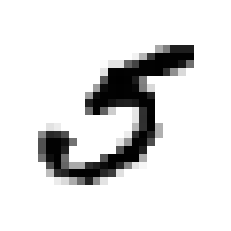

In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, 
           interpolation='nearest')
plt.axis('off')
plt.show()

In [15]:
y[36000]

5

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [17]:
# Shuffle the training set

import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

In [18]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5, y_test_5

(array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]))

In [21]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

In [25]:
# Implementing Cross-Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


/mnt/d/Users/billg/Documents/Science/env_test/env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.96295
0.9656
0.9689


In [30]:
y_train_5.size, "*****", y_train_folds.size

(60000, '*****', 40000)

In [31]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96295, 0.9656 , 0.9689 ])

In [32]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


In [33]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90905, 0.9094 , 0.9105 ])

In [36]:
# Confusion Matrix

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54046,   533],
       [ 1518,  3903]])

In [38]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [41]:
y_train_5.size, y_pred.size, y_train_pred.size

(60000, 20000, 60000)

In [45]:
### Precision and Recall

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8798467087466185, 0.719977863862756)

In [47]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7919245206452267

In [48]:
### Precision/Recall Tradeoff

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([1789.56694125])

In [50]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [51]:
threshold = 2000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [53]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                            method="decision_function")
# y_scores

In [54]:
y_scores

array([-12145.64302968, -34875.39346524, -10079.91695663, ...,
       -14281.19913643, -13576.72683046, -23833.31515574])

In [55]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [60]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])

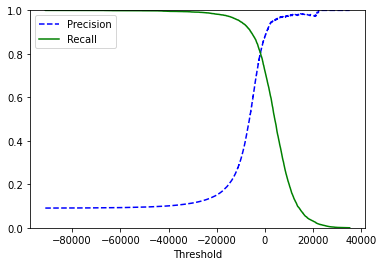

In [61]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [72]:
precisions.shape

(59703,)

In [73]:
precisions[:-1].shape

(59702,)

In [74]:
precisions, precisions[:-1]

(array([0.09080098, 0.09078575, 0.09078727, ..., 1.        , 1.        ,
        1.        ]),
 array([0.09080098, 0.09078575, 0.09078727, ..., 1.        , 1.        ,
        1.        ]))

In [78]:
y_train_pred_90 = (y_scores > 7000)
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9690831556503199, 0.33536247924737134)

In [79]:
### The ROC Curve

In [80]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [81]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

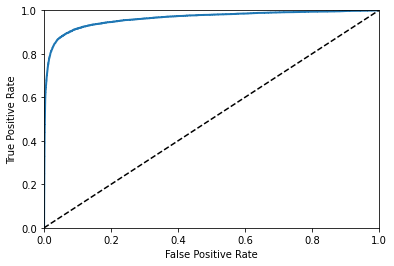

In [82]:
plot_roc_curve(fpr, tpr)
plt.show()

In [83]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9631312391283714

In [84]:
# P92
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                   method="predict_proba")

In [85]:
y_scores_forest = y_probas_forest[:, 1]    # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

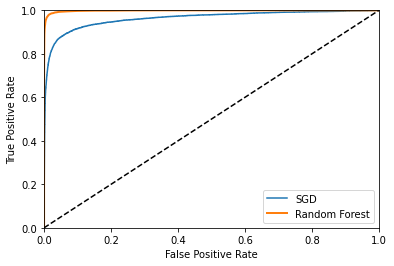

In [87]:
plt.plot(fpr, tpr, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

In [88]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984198933974858

## Multiclass Classification

In [89]:
# P94

sgd_clf.fit(X_train, y_train)    # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [97]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-15462.16047317, -25943.04288188, -11653.79161535,
         -3283.69332068, -13478.8782297 ,   2072.94625021,
        -16463.92439097, -16997.52089306, -10486.62402404,
        -11768.04200012]])

In [98]:
# P85
np.argmax(some_digit_scores)

5

In [99]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [101]:
sgd_clf.classes_[5]

5